# Necessary Downloads

In [1]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from collections import defaultdict

In [3]:
dataset = pd.read_csv('SMSSpamCollection', sep ='\t', names = ['label', 'reviews'])

In [4]:
dataset.head()

,label,reviews
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
dataset.shape

(5572, 2)

In [6]:
dataset['label'] = pd.get_dummies(dataset['label'], drop_first = True)

In [7]:
dataset.head()

,label,reviews
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# Data Visualization

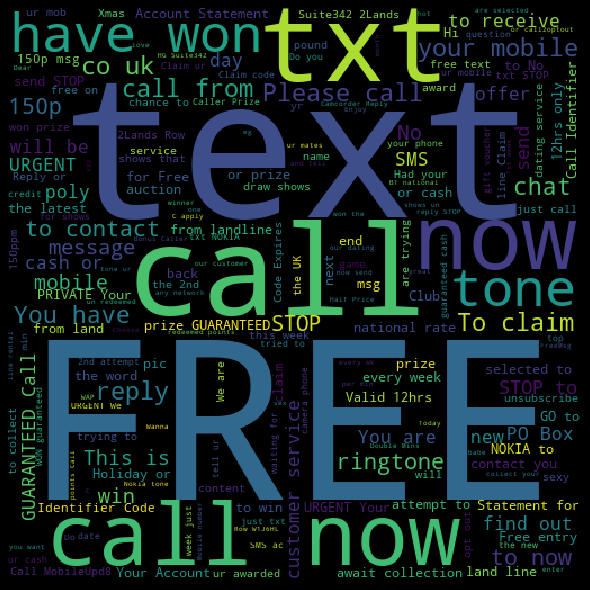

In [8]:
#Word cloud for spam messages
spam_words = ' '.join(dataset[dataset['label']==1]['reviews'])
spam_cloud = WordCloud(width = 512, height = 512).generate(spam_words)
plt.figure(figsize = (10,8), facecolor = 'k')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

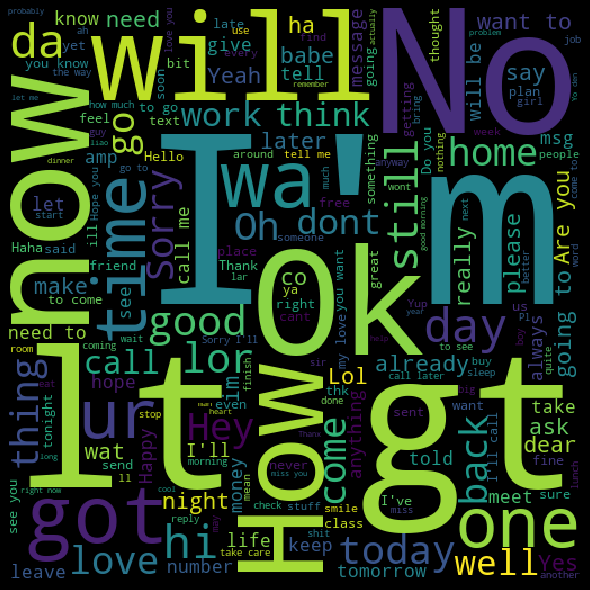

In [9]:
#Word cloud for non spam messages
spam_words = ' '.join(dataset[dataset['label']==0]['reviews'])
spam_cloud = WordCloud(width = 512, height = 512).generate(spam_words)
plt.figure(figsize = (10,8), facecolor = 'k')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [10]:
dataset.label.value_counts() 

0    4825
1     747
Name: label, dtype: int64

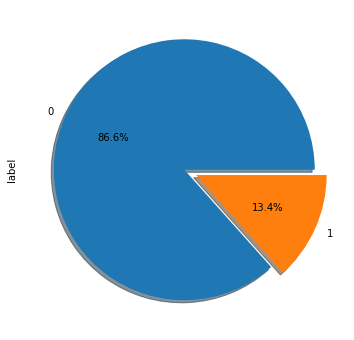

In [11]:
dataset["label"].value_counts().plot(kind = 'pie', explode = [0, 0.1],figsize = (6, 6), autopct = '%1.1f%%',shadow = True)

In [12]:
dataset['reviews'].apply(lambda x: len(x.split(' '))).mean()

15.709440057430006

In [13]:
top_sms = dataset.groupby("reviews")["label"].agg([len, np.max]).sort_values(by = "len", ascending = False).head(n = 10)
display(top_sms)

,len,amax
reviews,,
"Sorry, I'll call later",30,0
I cant pick the phone right now. Pls send a message,12,0
Ok...,10,0
Ok,4,0
Okie,4,0
"7 wonders in My WORLD 7th You 6th Ur style 5th Ur smile 4th Ur Personality 3rd Ur Nature 2nd Ur SMS and 1st ""Ur Lovely Friendship""... good morning dear",4,0
"Wen ur lovable bcums angry wid u, dnt take it seriously.. Coz being angry is d most childish n true way of showing deep affection, care n luv!.. kettoda manda... Have nice day da.",4,0
Your opinion about me? 1. Over 2. Jada 3. Kusruthi 4. Lovable 5. Silent 6. Spl character 7. Not matured 8. Stylish 9. Simple Pls reply..,4,0
Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed £1000 cash or £5000 prize!,4,1


# Preprocessing of Data

In [14]:
s = stopwords.words('english')
ps = nltk.wordnet.WordNetLemmatizer()
for i in range(dataset.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', dataset.loc[i,'reviews'])
    review = review.lower()
    review = review.split()
    review = [ps.lemmatize(word) for word in review if not word in s]
    review = ' '.join(review)
    dataset.loc[i, 'text'] = review
    
X = dataset['reviews']
y = dataset['label']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4457,), (1115,), (4457,), (1115,))

In [17]:
class NaiveBayes:
    
    def __init__(self,unique_classes):
        
        self.classes=unique_classes
        
    def addToBow(self,example,dict_index):

        if isinstance(example,np.ndarray): example=example[0]
     
        for token_word in example.split():
          
            self.bow_dicts[dict_index][token_word]+=1
            
    def train(self,dataset,labels):

        self.examples=dataset
        self.labels=labels
        self.bow_dicts=np.array([defaultdict(lambda:0) for index in range(self.classes.shape[0])])

        if not isinstance(self.examples,np.ndarray): self.examples=np.array(self.examples)
        if not isinstance(self.labels,np.ndarray): self.labels=np.array(self.labels)

        for cat_index,cat in enumerate(self.classes):
          
            all_cat_examples=self.examples[self.labels==cat]

            cleaned_examples=[cat_example for cat_example in all_cat_examples]
            
            cleaned_examples=pd.DataFrame(data=cleaned_examples)

            np.apply_along_axis(self.addToBow,1,cleaned_examples,cat_index)
            
        prob_classes=np.empty(self.classes.shape[0])
        all_words=[]
        cat_word_counts=np.empty(self.classes.shape[0])
        for cat_index,cat in enumerate(self.classes):
           
            prob_classes[cat_index]=np.sum(self.labels==cat)/float(self.labels.shape[0]) 
             
            count=list(self.bow_dicts[cat_index].values())
            cat_word_counts[cat_index]=np.sum(np.array(list(self.bow_dicts[cat_index].values())))+1
                                   
            all_words+=self.bow_dicts[cat_index].keys()
                                                     
        self.vocab=np.unique(np.array(all_words))
        self.vocab_length=self.vocab.shape[0]
                                                               
        denoms=np.array([cat_word_counts[cat_index]+self.vocab_length+1 for cat_index,cat in enumerate(self.classes)])                                                                          

        self.cats_info=[(self.bow_dicts[cat_index],prob_classes[cat_index],denoms[cat_index]) for cat_index,cat in enumerate(self.classes)]                               
        self.cats_info=np.array(self.cats_info)                                 
                                              
                                              
    def getExampleProb(self,test_example):                                
    
        likelihood_prob=np.zeros(self.classes.shape[0])
        
        for cat_index,cat in enumerate(self.classes): 
                             
            for test_token in test_example.split():
                        
                test_token_counts=self.cats_info[cat_index][0].get(test_token,0)+1
                                       
                test_token_prob=test_token_counts/float(self.cats_info[cat_index][2])                              
                
                likelihood_prob[cat_index]+=np.log(test_token_prob)
                
        post_prob=np.empty(self.classes.shape[0])
        for cat_index,cat in enumerate(self.classes):
            post_prob[cat_index]=likelihood_prob[cat_index]+np.log(self.cats_info[cat_index][1])                                  
      
        return post_prob
    
   
    def test(self,test_set):
       
        predictions=[]
        for example in test_set: 
                                                                               
            cleaned_example=(example) 
             
            post_prob=self.getExampleProb(cleaned_example)
            predictions.append(self.classes[np.argmax(post_prob)])
                
        return np.array(predictions)

In [18]:
nb=NaiveBayes(np.unique(y_train))

In [19]:
nb.train(X_train,y_train)

In [20]:
y_pred=nb.test(X_test)

In [21]:
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,classification_report

In [22]:
accuracy_score(y_test,y_pred)

0.967713004484305

In [23]:
cm=confusion_matrix(y_test,y_pred)
cm

array([[926,  29],
       [  7, 153]], dtype=int64)

In [24]:
f1_score(y_test,y_pred)

0.8947368421052633

In [25]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       955
           1       0.84      0.96      0.89       160

    accuracy                           0.97      1115
   macro avg       0.92      0.96      0.94      1115
weighted avg       0.97      0.97      0.97      1115

